In [70]:
import gpxpy, geopandas, json
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import haversine

from geopy import distance
from math import sqrt, floor
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString
from ipyleaflet import Map, GeoData, basemaps, LayersControl

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

gpx_file = open('data/myGPX.gpx', 'r')
gpx = gpxpy.parse(gpx_file)

In [71]:
def gpx2df(gpx):    
    data = gpx.tracks[0].segments[0].points

    ## Start Position
    start = data[0]
    ## End Position
    finish = data[-1]

    df = pd.DataFrame(columns=['lon', 'lat', 'alt', 'time'])
    for point in data:
        df = df.append({'lon': point.longitude, 'lat' : point.latitude, 'alt' : point.elevation, 'time' : point.time}, ignore_index=True)
    df['time'] = df['time'].astype(str).str[:-6]
    df['time'] = pd.to_datetime(df['time'], dayfirst=True)
    return data, df

In [72]:
data,df = gpx2df(gpx)

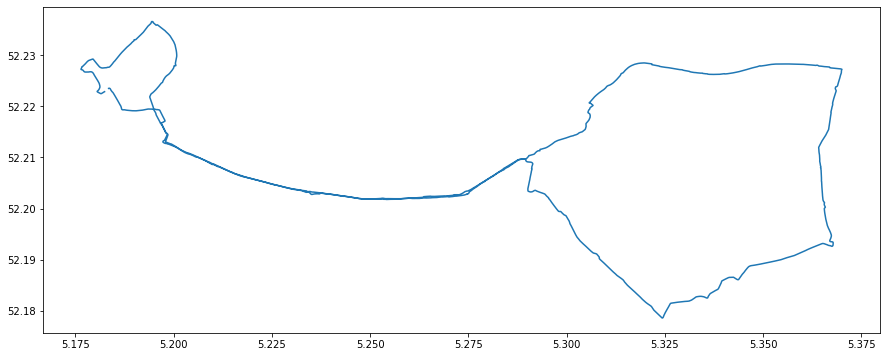

In [73]:
rcParams['figure.figsize'] = 15, 6
plt.plot(df['lon'], df['lat'])

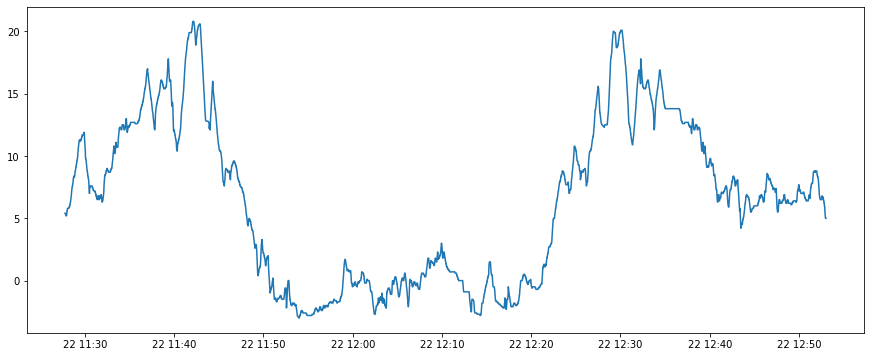

In [74]:
# Looking into the altitudes
plt.plot(df['time'], df['alt'])

In [76]:
#Transformation

alt_dif = [0]
time_dif = [0]
dist_vin = [0]
dist_hav = [0]
dist_vin_no_alt = [0]
dist_hav_no_alt = [0]
dist_dif_hav_2d = [0]
dist_dif_vin_2d = [0]
for index in range(len(data)):
    if index == 0:
        pass
    else:
        start = data[index-1]
        stop = data[index]
        
        distance_vin_2d = distance.vincenty((start.latitude, start.longitude), (stop.latitude, stop.longitude)).m
        dist_dif_vin_2d.append(distance_vin_2d)
        distance_hav_2d = haversine.haversine((start.latitude, start.longitude), (stop.latitude, stop.longitude))*1000
        dist_dif_hav_2d.append(distance_hav_2d)
        dist_vin_no_alt.append(dist_vin_no_alt[-1] + distance_vin_2d)
        dist_hav_no_alt.append(dist_hav_no_alt[-1] + distance_hav_2d)
        alt_d = start.elevation - stop.elevation
        alt_dif.append(alt_d)
        distance_vin_3d = sqrt(distance_vin_2d**2 + (alt_d)**2)
        distance_hav_3d = sqrt(distance_hav_2d**2 + (alt_d)**2) 
        time_delta = (stop.time - start.time).total_seconds()
        time_dif.append(time_delta)
        dist_vin.append(dist_vin[-1] + distance_vin_3d)
        dist_hav.append(dist_hav[-1] + distance_hav_3d)
        
df['dis_vin_2d'] = dist_vin_no_alt 
df['dist_hav_2d'] = dist_hav_no_alt
df['dis_vin_3d'] = dist_vin
df['dis_hav_3d'] = dist_hav
df['alt_dif'] = alt_dif
df['time_dif'] = time_dif
df['dis_dif_hav_2d'] = dist_dif_hav_2d
df['dis_dif_vin_2d'] = dist_dif_vin_2d

df['dist_dif_per_sec'] = df['dis_dif_hav_2d'] / df['time_dif']
for treshold in [0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    print(treshold, 'm', ' : Time:', 
          sum(df[df['dist_dif_per_sec'] < treshold]['time_dif']),
         ' seconds')

df['spd'] = (df['dis_dif_hav_2d'] / df['time_dif']) * 3.6
df_with_timeout = df[df['dist_dif_per_sec'] > 0.9]
avg_km_h = (sum((df_with_timeout['spd'] * 
                 df_with_timeout['time_dif'])) / 
            sum(df_with_timeout['time_dif']))
print(floor(60 / avg_km_h), 'minutes',
      round(((60 / avg_km_h - floor(60 / avg_km_h))*60), 0),
     ' seconds')
df['time10s'] = list(map(lambda x: round(x, -1)
                         , np.cumsum(df['time_dif'])))

/Users/rkopei/Documents/GitHub/Productionize/venv/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning:

Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.



0.5 m  : Time: 122.0  seconds
0.6 m  : Time: 129.0  seconds
0.7 m  : Time: 129.0  seconds
0.8 m  : Time: 139.0  seconds
0.9 m  : Time: 143.0  seconds
1 m  : Time: 153.0  seconds
2 minutes 2.0  seconds


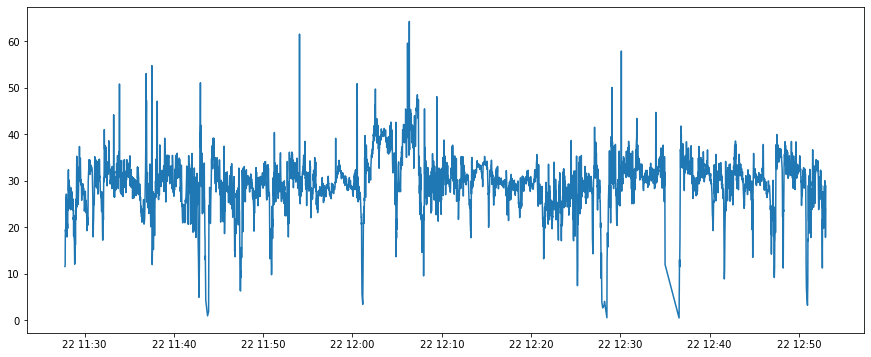

In [77]:
plt.plot(df.groupby(['time']).mean()['spd'])

In [79]:
def positive_only(x):
    if x > 0:
        return x
    else:
        return 0
pos_only = list(map(positive_only, df['alt_dif']))
sum(list(map(lambda x: round(x,0) , pos_only)))

3.0

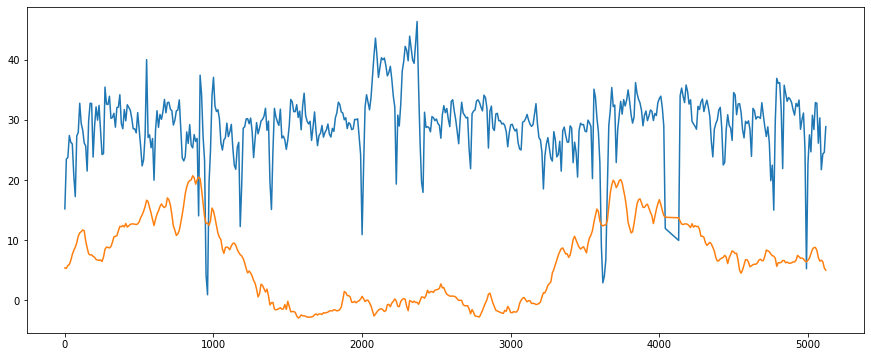

In [80]:
plt.plot(df.groupby(['time10s']).mean()['spd'])
plt.plot(df.groupby(['time10s']).mean()['alt'])

In [81]:
# Create Geopandas Dataframe
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(df, crs=crs, geometry=geometry)
gdf['entity_id']=gdf.index

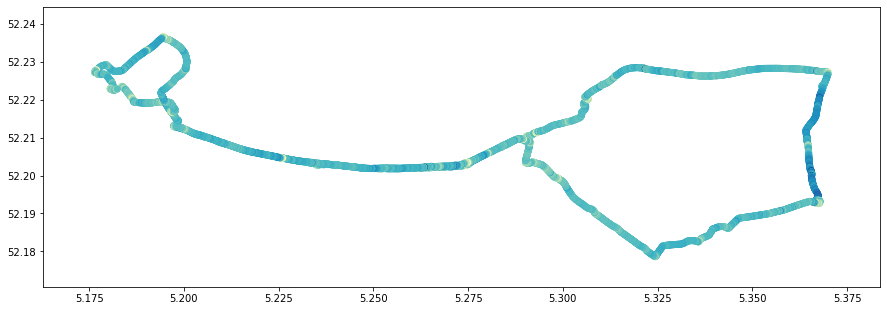

In [82]:
# Lets plot it and classify through speed
fig, ax = plt.subplots(figsize=(15,12), subplot_kw={'aspect':'equal'})
gdf.plot(column='spd',cmap='YlGnBu',ax=ax)

In [67]:
# Aggregate these points with the GroupBy
geo_df = GeoDataFrame(gdf, geometry='geometry')

geo_df['cl']=1
# TODO: split into reasonable number of LineStrings
# For example: geo_df['cl'].loc[geo_df['entity_id'] <= 1000] = 10

# Create GeoDataFrame for the Linestring
geo_df = geo_df.groupby(['cl'])['geometry'].apply(lambda x: LineString(x.tolist()) if x.size > 1 else x.tolist())
geo_df = GeoDataFrame(geo_df, geometry='geometry')

In [63]:
# Visualize route
m = Map(center=(52.20,5.28), zoom = 10, basemap= basemaps.Esri.WorldTopoMap)
geo_data = GeoData(geo_dataframe = geo_df)

m.add_layer(geo_data)
m.add_control(LayersControl())
m

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}…